In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import cv2
from camutils import *
from visutils import *
from meshGeneration import *
from scipy.spatial import Delaunay
import trimesh
import math
from meshutils import *
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize']=[15,15] #adjust this as needed to get clearly visible figures

**Calibrate Camera**

Using calibrate.py, we are getting an accurate estiamte of the intrinsic paramters for the scanner from the calib_jpg_u directory. With these intrinsic paramters, we can also determenin the extrinsic paramters of the camera.

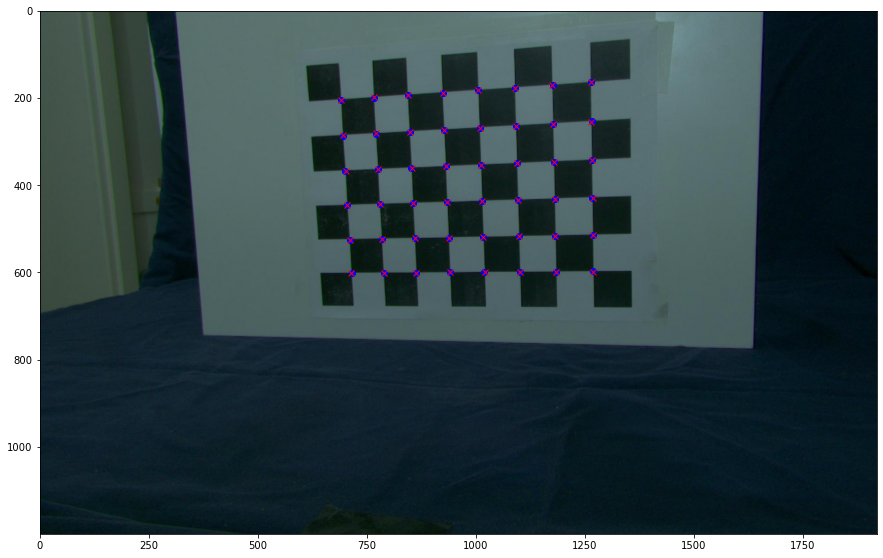

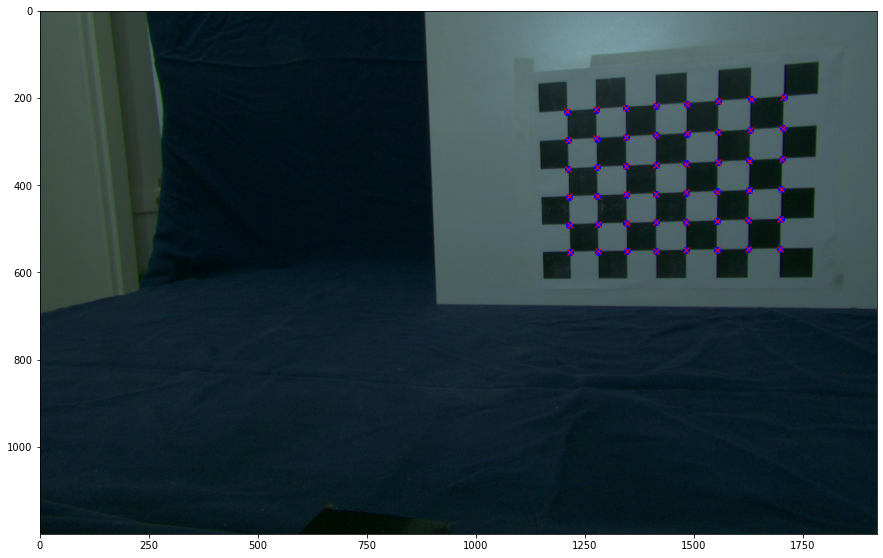

In [5]:
#calibrate.py has ran before executing this cell

#load intrinsic paramters from calibrate.py
file = open('calibration.pickle','rb')
intrisic_params = pickle.load(file)
intrisic_f=(intrisic_params["fx"]+intrisic_params["fy"])/2.0
intrisic_c=np.array([[intrisic_params["cx"],intrisic_params["cy"]]]).T

#create Camera objects using the known,loaded intrinsic paramters
cam1 = Camera(f=intrisic_f,c=intrisic_c,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
cam2 = Camera(f=intrisic_f,c=intrisic_c,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

# loading the first and second images from calib_jpg_u to find coordinates of the chessboard corners using OpenCV
img1 = plt.imread('calib_jpg_u/frame_C0_01.jpg')
ret, corners1 = cv2.findChessboardCorners(img1, (8,6), None)
pts2_1 = corners1.squeeze().T

img2 = plt.imread('calib_jpg_u/frame_C0_02.jpg')
ret, corners2 = cv2.findChessboardCorners(img2, (8,6), None)
pts2_2 = corners2.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


#initalize params then run calibratePose to get extrinsic paramters
params1 = np.array([0,0,45,2,0,-1])
params2 = np.array([0,0,0,-3,0,-5])

cam1 = calibratePose(pts3,pts2_1,cam1,params1)
cam2 = calibratePose(pts3,pts2_2,cam2,params2)

#Display reprojected points to make sure they line up and parameters are accruate
plt.rcParams['figure.figsize']=[15,15]
pts2_1p = cam1.project(pts3)
plt.imshow(img1)
plt.plot(pts2_1p[0,:],pts2_1p[1,:],'bo')
plt.plot(pts2_1[0,:],pts2_1[1,:],'rx')
plt.show()

pts2_2p = cam2.project(pts3)
plt.imshow(img2)
plt.plot(pts2_2p[0,:],pts2_2p[1,:],'bo')
plt.plot(pts2_2[0,:],pts2_2[1,:],'rx')
plt.show()



**Generate Object Mask**

Compute Object mask from the color image and background image and compare it to a threshold to determine if the pixel is part of the object. This will help to elimiate background pixels. We will pass this mask into reconstruct where we can apply it to on top of the mask returned by decode()

Squared Difference Mask vs Thresholding Mask Visual Check


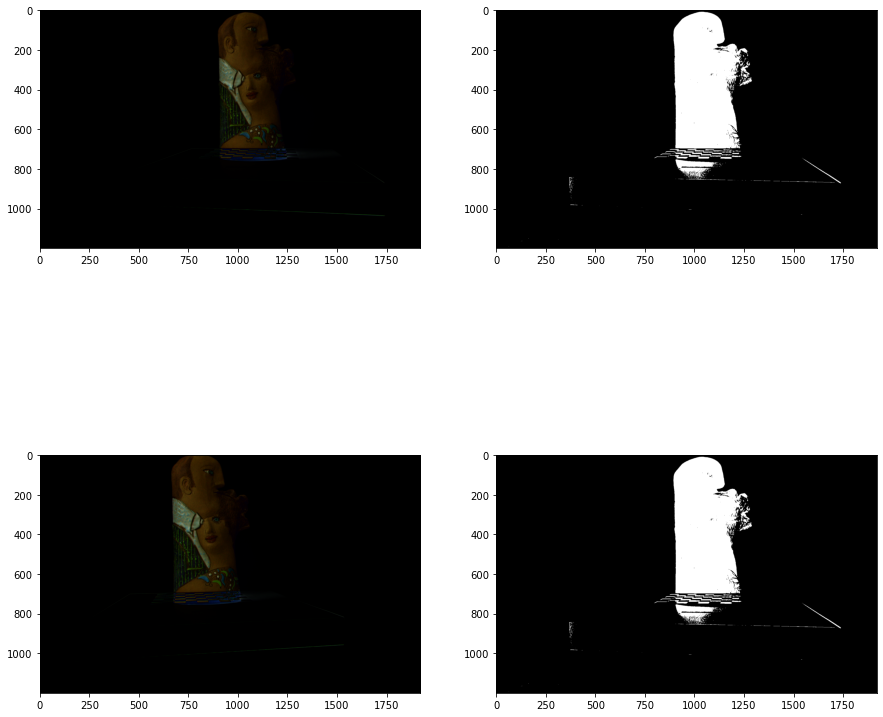

In [17]:
imgL_bg = plt.imread("couple/grab_0_u/color_C0_00.png")
imgL = plt.imread("couple/grab_0_u/color_C0_01.png") 
imgR_bg = plt.imread("couple/grab_0_u/color_C1_00.png")
imgR = plt.imread("couple/grab_0_u/color_C1_01.png")
imageList=[imgL,imgL_bg,imgR,imgR_bg]
objMaskL,objMaskR=camutils.getObjectMask(imageList,.05)


maskL=(imgL_bg-imgL)**2
maskR=(imgR-imgR_bg)**2

print("Squared Difference Mask vs Thresholding Mask Visual Check")
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(maskL,cmap="gray")
axarr[0,1].imshow(objMaskL,cmap="gray")
axarr[1,0].imshow(maskR,cmap="gray")
axarr[1,1].imshow(objMaskL,cmap="gray")

In [11]:
def genMesh(dirName,cam1,cam2,decodeThresh,objectThresh,boxlimits,triPruningThresh,numTimesSmooth,filename):
    imprefix1=dirName+"/frame_C0_"
    imprefix2=dirName+"/frame_C1_"
    threshold = .02
    objectThresh=.055
    imgL_bg = plt.imread(dirName+"/color_C0_00.png")
    imgL = plt.imread(dirName+"/color_C0_01.png")
    imgR_bg = plt.imread(dirName+"/color_C1_00.png")
    imgR = plt.imread(dirName+"/color_C1_01.png")
    imageList=[imgL,imgL_bg,imgR,imgR_bg]


    pts2L,pts2R,pts3,color=reconstruct(imprefix1,imprefix2,decodeThresh,cam1,cam2,imageList,objectThresh)
    
    boundingBoxPruning(boxlimits,pts3,pts2L,pts2R,color)
    tri = Delaunay(pts2L.T)
    trianglePruning(tri,triPruningThresh)
    nDict=createNeighborDict(tri.simplices)
    smoothMesh(nDict,pts3,numTimesSmooth)
    writeply(pts3,color,tri.simplices,filename)
   

In [18]:
import time
start=time.time()
decodeThresh=.02
objectThresh=.05
boxlimits = np.array([0,300,0,300,0,300])
triPruningThresh=20
numTimesSmooth=3

for i in range(7):
    dirName="couple/grab_"+str(i)+"_u"
    fileName="coupleMesh"+str(i)+".ply"
    print("generatingMesh for "+dirName)
    genMesh(dirName,cam1,cam2,decodeThresh,objectThresh,boxlimits,triPruningThresh,numTimesSmooth,fileName)
    
finish=time.time()
print(finish-start)

generatingMesh for couple/grab_0_u
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

generatingMesh for couple/grab_1_u
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

generatingMesh for couple/grab_2_u
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 